In [1]:
import numpy as np
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from glob import glob

In [2]:
%pwd

'/nfs/nhome/live/wdorrell/modular'

In [45]:
date = '20240517'
files = os.listdir(f'./data/{date}')

save_files = []
config_files = []
counter = 0
for file in files:
    path = f'./data/{date}/{file}/' 
    files_to_maybe_load = glob(path + 'params_*_*.npy')
    min_loss = np.inf
    for file in files_to_maybe_load:
        position_ = file.rfind('_')
        position_stop = file.rfind('.')
        loss = float(file[position_+1:position_stop])
        if loss < min_loss:
            file_to_load = file
            min_loss = loss
    
    config = np.load(path + 'config_dict.npy', allow_pickle=True)[()]
    if config['num_stim'] == 3:
        print(f'{counter}: {file_to_load}')
        print(config['mu_W'], config['repeats'])
        counter += 1
        
        save_files.append(file_to_load)
        config_files.append(path + 'config_dict.npy')


0: ./data/20240517/06:56:21_5214/params_3106621_54.78407.npy
0.025 1
1: ./data/20240517/06:56:21_8342/params_3280023_53.34786.npy
0.025 1
2: ./data/20240517/06:56:21_9107/params_5613137_53.93769.npy
0.025 1
3: ./data/20240517/06:56:21_9840/params_3168314_53.33737.npy
0.025 1
4: ./data/20240517/06:56:21_5258/params_4357617_53.58358.npy
0.025 1
5: ./data/20240517/06:56:23_6662/params_2885194_45.16768.npy
0.025 0
6: ./data/20240517/06:56:23_4681/params_3466496_44.40594.npy
0.025 0
7: ./data/20240517/06:56:23_4568/params_4378819_44.36658.npy
0.025 0
8: ./data/20240517/06:56:23_7405/params_1804160_44.74343.npy
0.025 0
9: ./data/20240517/06:56:24_7953/params_3403387_44.29547.npy
0.025 0
10: ./data/20240517/06:56:51_119/params_14829508_49.54411.npy
0.025 1
11: ./data/20240517/06:56:51_4914/params_15677511_48.79889.npy
0.025 1
12: ./data/20240517/06:56:51_6546/params_15926671_48.64872.npy
0.025 1
13: ./data/20240517/06:56:51_3385/params_34752960_48.66511.npy
0.025 1
14: ./data/20240517/06:56:5

In [54]:
num = 27

params = np.load(save_files[num], allow_pickle=True)[()]
config = np.load(config_files[num], allow_pickle=True)[()]

In [55]:
config

{'repeats': 1,
 'reward': 0,
 'num_stim': 3,
 'save_iter': 50000,
 'T': 10000000000,
 'learning_rate': 1e-06,
 'random_seed': 7947,
 'N': 35,
 'mu_fit': 100000,
 'mu_G': 250,
 'mu_W': 0.025,
 'mu_R': 0.025,
 'mu_pos': 10000,
 'fit_thresh': 0.01}

In [56]:
# Use these to calculate the number of trials, how long each trial is, and num conditions
num_trials = config['num_stim']*(config['num_stim']-(1-config['repeats'])) 
task_len = 5 + config['reward']
D = task_len*num_trials # Total number of conditions

# Create inputs and outputs
inputs = np.zeros([config['num_stim'], D])
outputs = np.zeros([config['num_stim']+config['reward'], D])
counter = 0
for target_1 in range(config['num_stim']):
    for target_2 in range(config['num_stim']):
        if target_2 != target_1 or config['repeats']:
            inputs[target_1,counter] = 1
            inputs[target_2,counter + 1] = 1

            outputs[target_1,counter+3] = 1
            outputs[target_2,counter+4] = 1
            if config['reward']:
                outputs[config['num_stim'],counter+5] = 1
            counter += task_len
            
# Now stack a bias on the inputs
inputs = np.vstack([inputs, np.ones([1, inputs.shape[1]])])

In [57]:

def generate_rep(params, inputs):
    g = jnp.zeros([config['N']+1, D])
    g = g.at[-1:,:].set(np.ones([1,g.shape[1]]))
    g = g.at[:-1,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,task_len):
        g = g.at[:-1,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W"]@g[:,t-1::task_len])
    return g

# PC extracting function
def get_PCs(vecs, num_eigs = 2):
    vecs = vecs - np.mean(vecs, axis = 1)[:,None]
    covar = vecs@vecs.T
    eigvals, eigvecs = np.linalg.eig(covar)
    
    ordering = np.argsort(eigvals)[::-1]
    #print(f"Propotion of Activity Kept: {np.sum(eigvals[ordering[:2]])/np.sum(eigvals)}")
    return np.real(eigvecs[:,ordering[:num_eigs]])

# Subspace angle calculating function
def calculate_angles(g, inputs, num_eigs = 2):
    inputs_1 = inputs[:3,0::task_len]
    inputs_2 = inputs[:3,1::task_len]
    inputs_both = [inputs_1, inputs_2]
    
    PCs = np.zeros([N, 2, num_eigs])
    for order in range(2):
        diff_vec = []
        for q in range(3):
            indices = np.where(inputs_both[order][q,:] == 1)[0]
            for index in range(len(indices)):
                for index2 in range(index):
                    if index != index2:
                        diff_vec.append(g[:,indices[index]] - g[:,indices[index2]])
        diff_vec = np.stack(diff_vec).T
        PCs[:,order,:] = get_PCs(diff_vec, num_eigs = num_eigs)      

    U, S, V = np.linalg.svd(PCs[:,0,:].T@PCs[:,1,:])
    angles = np.arccos(S)/np.pi*180
    return angles


def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(config['N']+1)), mat1)
    return mat2

@jit
def loss_R(R):
    return jnp.linalg.norm(generate_R(g, targets))**2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds)

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params, inputs)
    R = generate_R(g, outputs)
    
    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_W*(loss_weight(params["W"])) + mu_R*(loss_weight_I(params["I"]) + loss_weight(R)) + mu_pos*loss_pos(g)

In [58]:
params['I'].shape

(35, 4)

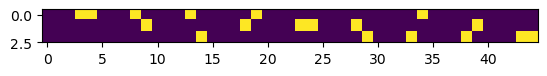

In [59]:
plt.imshow(outputs)

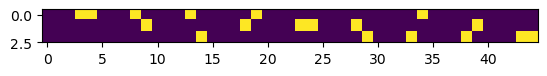

In [60]:
g = generate_rep(params, inputs)
R = generate_R(g, outputs)

preds = R.T@g
plt.imshow(preds)

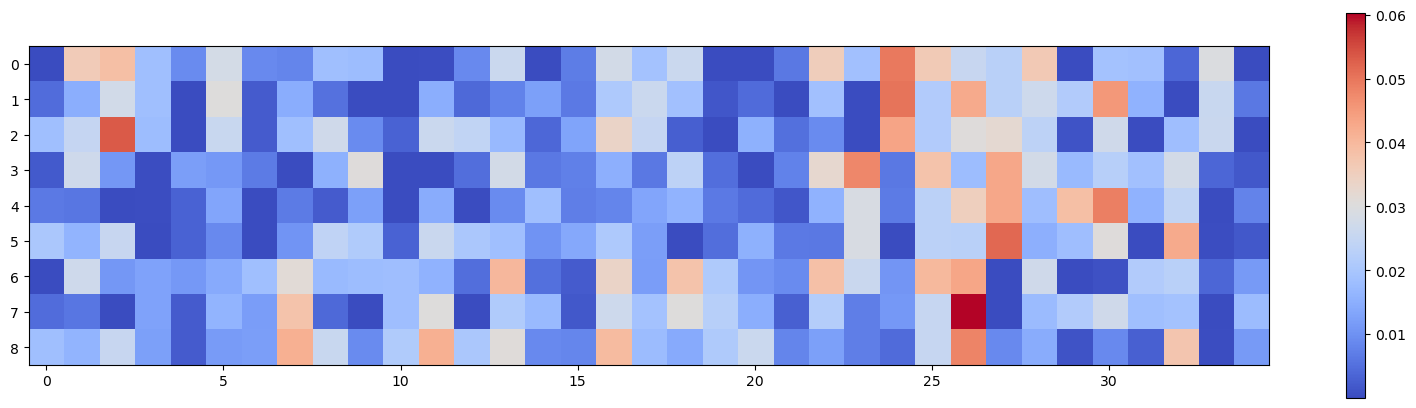

In [61]:
plt.figure(figsize = (20, 5))
plt.imshow(g[:-1,2::task_len].T, cmap='coolwarm')
plt.colorbar()

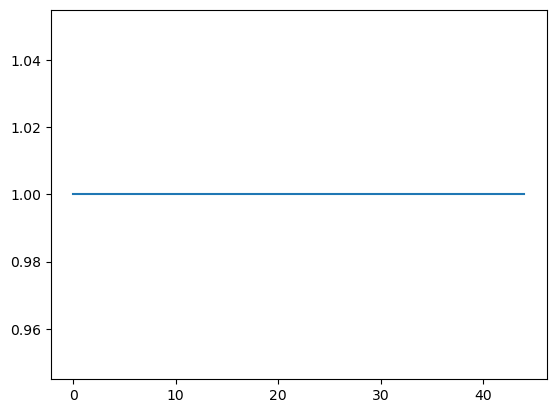

In [62]:
plt.plot(g[-1,:])